In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 16.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 req

In [ ]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout


In [ ]:
# 예시: 30000개 라벨링 완료된 파일
df = pd.read_csv("yogiyo_reviews_labeled_30000.csv")  # 실제 파일명에 맞게 수정
df = df[df['sentiment'].isin(['positive', 'negative'])].copy()  # 감성 라벨 이진화


In [ ]:
def tokenize(text):
    text = re.sub(r"[^\uAC00-\uD7A3\s]", "", str(text))
    return text.split()

tokenized_texts = df['content'].apply(tokenize).tolist()
texts_joined = [' '.join(tokens) for tokens in tokenized_texts]


In [ ]:
# 감성 라벨 (0: negative, 1: positive)
y_sentiment = LabelEncoder().fit_transform(df['sentiment'])

# 요구사항 라벨 (True/False → 1/0)
y_requirement = df['requirement'].astype(int).values


In [ ]:
# 감성 라벨 (0: negative, 1: positive)
y_sentiment = LabelEncoder().fit_transform(df['sentiment'])

# 요구사항 라벨 (True/False → 1/0)
y_requirement = df['requirement'].astype(int).values


In [ ]:
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=2, workers=2)


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts_joined)
sequences = tokenizer.texts_to_sequences(texts_joined)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
max_len = 30
X = pad_sequences(sequences, maxlen=max_len)


In [ ]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]


In [ ]:
X_train, X_test, y_sentiment_train, y_sentiment_test, y_requirement_train, y_requirement_test = train_test_split(
    X, y_sentiment, y_requirement, test_size=0.2, random_state=42
)


In [ ]:
input_ = Input(shape=(max_len,))
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(input_)
x = LSTM(64, return_sequences=False)(x)
x = Dropout(0.4)(x)

out_sentiment = Dense(1, activation='sigmoid', name='sentiment_output')(x)
out_requirement = Dense(1, activation='sigmoid', name='requirement_output')(x)

model = Model(inputs=input_, outputs=[out_sentiment, out_requirement])
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics={'sentiment_output': 'accuracy', 'requirement_output': 'accuracy'}
)
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 30, 100)   │  5,514,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     42,240 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentiment_output    │ (None, 1)         │         65 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ requirement_output  │ (None, 1)         │         65 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,556,370 (21.20 MB)

 Trainable params: 5,556,370 (21.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(
    X_train,
    [y_sentiment_train, y_requirement_train],
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    verbose=2
)


Epoch 1/5
321/321 - 34s - 106ms/step - loss: 0.3874 - requirement_output_accuracy: 0.9830 - requirement_output_loss: 0.0737 - sentiment_output_accuracy: 0.8636 - sentiment_output_loss: 0.3137 - val_loss: 0.2954 - val_requirement_output_accuracy: 0.9847 - val_requirement_output_loss: 0.0676 - val_sentiment_output_accuracy: 0.9066 - val_sentiment_output_loss: 0.2269
Epoch 2/5
321/321 - 40s - 125ms/step - loss: 0.1943 - requirement_output_accuracy: 0.9877 - requirement_output_loss: 0.0578 - sentiment_output_accuracy: 0.9505 - sentiment_output_loss: 0.1365 - val_loss: 0.2829 - val_requirement_output_accuracy: 0.9847 - val_requirement_output_loss: 0.0626 - val_sentiment_output_accuracy: 0.9132 - val_sentiment_output_loss: 0.2201
Epoch 3/5
321/321 - 41s - 128ms/step - loss: 0.0867 - requirement_output_accuracy: 0.9891 - requirement_output_loss: 0.0424 - sentiment_output_accuracy: 0.9863 - sentiment_output_loss: 0.0443 - val_loss: 0.3316 - val_requirement_output_accuracy: 0.9737 - val_require

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
✅ 감성 분류 평가
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1269
           1       0.94      0.95      0.95      4434

    accuracy                           0.92      5703
   macro avg       0.88      0.87      0.87      5703
weighted avg       0.91      0.92      0.91      5703


✅ 요구사항 분류 평가
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      5628
           1       0.09      0.57      0.16        75

    accuracy                           0.92      5703
   macro avg       0.54      0.75      0.56      5703
weighted avg       0.98      0.92      0.95      5703



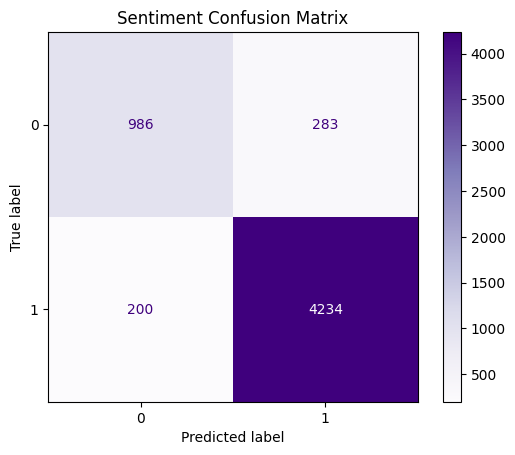

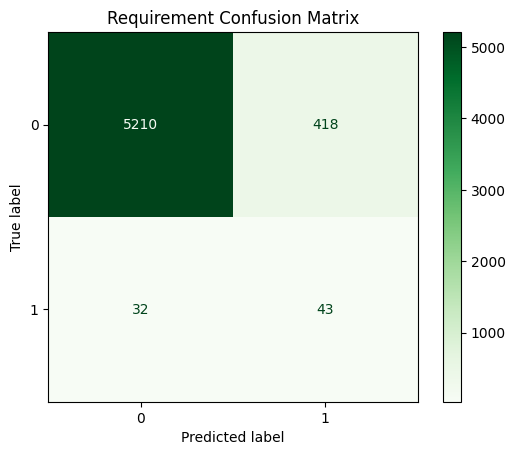

In [ ]:
pred_sent, pred_req = model.predict(X_test)
pred_sent = (pred_sent > 0.5).astype(int).flatten()
pred_req = (pred_req > 0.5).astype(int).flatten()

print("✅ 감성 분류 평가")
print(classification_report(y_sentiment_test, pred_sent))

print("\n✅ 요구사항 분류 평가")
print(classification_report(y_requirement_test, pred_req))

cm1 = confusion_matrix(y_sentiment_test, pred_sent)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp1.plot(cmap='Purples')
plt.title("Sentiment Confusion Matrix")
plt.show()

cm2 = confusion_matrix(y_requirement_test, pred_req)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp2.plot(cmap='Greens')
plt.title("Requirement Confusion Matrix")
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 30, 100)   │  5,514,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128)       │    117,248 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentiment_output    │ (None, 1)         │        129 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ requirement_output  │ (None, 1)         │        129 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,631,506 (21.48 MB)

 Trainable params: 5,631,506 (21.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
321/321 - 44s - 136ms/step - loss: 0.3641 - requirement_output_accuracy: 0.9852 - requirement_output_loss: 0.0703 - sentiment_output_accuracy: 0.8724 - sentiment_output_loss: 0.2939 - val_loss: 0.3235 - val_requirement_output_accuracy: 0.9847 - val_requirement_output_loss: 0.0676 - val_sentiment_output_accuracy: 0.8878 - val_sentiment_output_loss: 0.2544
Epoch 2/15
321/321 - 33s - 103ms/step - loss: 0.1830 - requirement_output_accuracy: 0.9877 - requirement_output_loss: 0.0563 - sentiment_output_accuracy: 0.9529 - sentiment_output_loss: 0.1267 - val_loss: 0.2778 - val_requirement_output_accuracy: 0.9847 - val_requirement_output_loss: 0.0632 - val_sentiment_output_accuracy: 0.9176 - val_sentiment_output_loss: 0.2145
Epoch 3/15
321/321 - 35s - 108ms/step - loss: 0.0833 - requirement_output_accuracy: 0.9883 - requirement_output_loss: 0.0450 - sentiment_output_accuracy: 0.9890 - sentiment_output_loss: 0.0382 - val_loss: 0.3149 - val_requirement_output_accuracy: 0.9790 - val_requ

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


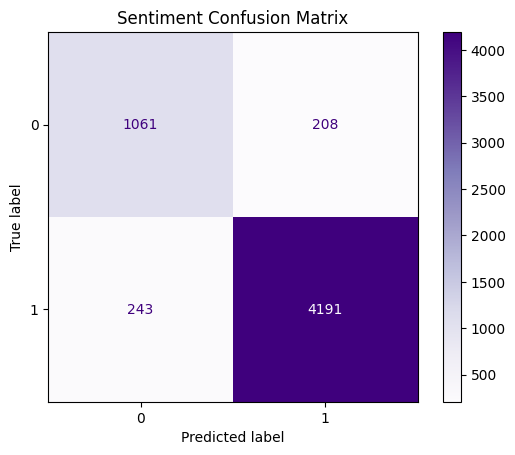

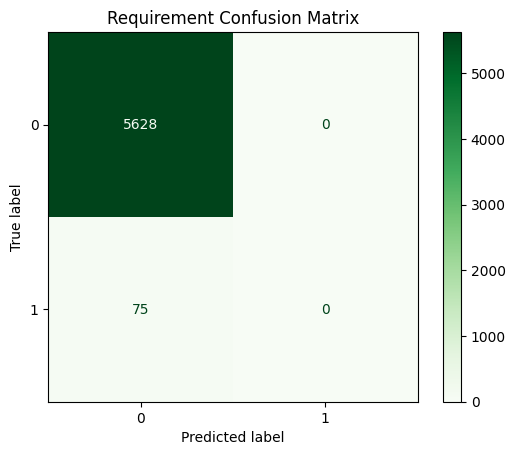

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# ✅ EarlyStopping 콜백 설정
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# ✅ 모델 구성 (LSTM 128, Dropout 0.3)
input_ = Input(shape=(max_len,))
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(input_)
x = LSTM(128, return_sequences=False)(x)
x = Dropout(0.3)(x)

out_sentiment = Dense(1, activation='sigmoid', name='sentiment_output')(x)
out_requirement = Dense(1, activation='sigmoid', name='requirement_output')(x)

model = Model(inputs=input_, outputs=[out_sentiment, out_requirement])
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics={'sentiment_output': 'accuracy', 'requirement_output': 'accuracy'}
)
model.summary()

# ✅ 모델 학습 (epochs 15 + early stopping)
model.fit(
    X_train,
    [y_sentiment_train, y_requirement_train],
    epochs=15,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=2
)

# ✅ 평가
pred_sent, pred_req = model.predict(X_test)
pred_sent = (pred_sent > 0.5).astype(int).flatten()
pred_req = (pred_req > 0.5).astype(int).flatten()

print("✅ 감성 분류 평가")
print(classification_report(y_sentiment_test, pred_sent))

print("\n✅ 요구사항 분류 평가")
print(classification_report(y_requirement_test, pred_req))

cm1 = confusion_matrix(y_sentiment_test, pred_sent)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp1.plot(cmap='Purples')
plt.title("Sentiment Confusion Matrix")
plt.show()

cm2 = confusion_matrix(y_requirement_test, pred_req)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp2.plot(cmap='Greens')
plt.title("Requirement Confusion Matrix")
plt.show()


In [ ]:
# ✅ 필수 라이브러리 설치
!pip install rake-nltk

# ✅ 불용어 오류 방지를 위한 리소스 다운로드
import nltk
nltk.download('stopwords')
# ✅ Punkt tokenizer 리소스 다운로드 (RAKE가 필요로 함)
nltk.download('punkt_tab')

# ✅ 라이브러리 불러오기
from rake_nltk import Rake
import pandas as pd

# ✅ 1. 요구사항 있는 리뷰만 추출
df_req = df[df['requirement'] == True].copy()
print(f"요구사항 포함 리뷰 수: {len(df_req)}")

# ✅ 2. 한국어 불용어 수동 지정 (RAKE는 영어 기준 → 한국어 맞춤 대응)
korean_stopwords = ['이', '그', '저', '더', '좀', '정말', '진짜', '그리고', '때문에', '것', '수', '있다', '없다', '에서', '입니다']

# ✅ 3. RAKE 객체 초기화
rake = Rake(stopwords=korean_stopwords)

# ✅ 4. 키워드 추출 함수 정의
def extract_keywords_rake(text, top=3):
    rake.extract_keywords_from_text(str(text))
    return rake.get_ranked_phrases()[:top]

# ✅ 5. 키워드 추출 적용
df_req['keywords'] = df_req['content'].apply(lambda x: extract_keywords_rake(x))

# ✅ 6. 일부 결과 출력
for i in range(min(10, len(df_req))):
    print(f"리뷰: {df_req.iloc[i]['content']}")
    print(f"핵심 키워드: {df_req.iloc[i]['keywords']}")
    print('-'*60)

# ✅ 7. 결과를 엑셀로 저장
df_req[['content', 'keywords']].to_excel("요구사항_리뷰_핵심키워드.xlsx", index=False)
print("✅ 결과 저장 완료: '요구사항_리뷰_핵워드.xlsx'")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


요구사항 포함 리뷰 수: 363
리뷰: 배달원이 배달완료 문자안보낸것 때문에 저랑.상담사.요기요. 이 셋만 피곤해지는게 뭔 상황인가 싶네요 대처도 안된다는게 참.. 죄송할 필요가없는 상담사분만 죄송하다고하고 정작 사고친 당사자는 나몰라라하고 너무 어이가없네요ㅋㅋ 상담사분은 특히나 뭔 죄이신지.. 제가 다 죄송하더군요 이건 빨리 개선됐으면 합니다 너무 불합리하네요 25년 6월 8일 이문제 여태 안고쳐지네요 개판이네ㅋㅋ
핵심 키워드: ['셋만 피곤해지는게 뭔 상황인가 싶네요 대처도 안된다는게 참 .. 죄송할 필요가없는 상담사분만 죄송하다고하고 정작 사고친 당사자는 나몰라라하고 너무 어이가없네요ㅋㅋ 상담사분은 특히나 뭔 죄이신지 .. 제가 다 죄송하더군요 이건 빨리 개선됐으면 합니다 너무 불합리하네요 25년 6월 8일 이문제 여태 안고쳐지네요 개판이네ㅋㅋ', '배달원이 배달완료 문자안보낸것', '저랑']
------------------------------------------------------------
리뷰: 유린기 소스 끝내줘요. 소스 남으면 두부조림(많이 다니까 간장추가) 등조림에 써요 짜장소스는 야채 많이 추가해서 볶으면 훌륭한 짜장이 되서 햇반하고 먹으면 여러 명이 짜장 밥 잔치해도 되요. 유린기는 맛있고 양도 푸짐합니다.
핵심 키워드: ['등조림에 써요 짜장소스는 야채 많이 추가해서 볶으면 훌륭한 짜장이 되서 햇반하고 먹으면 여러 명이 짜장 밥 잔치해도 되요', '많이 다니까 간장추가', '유린기는 맛있고 양도 푸짐합니다']
------------------------------------------------------------
리뷰: 로그인 방법 중 네이버 로그인을 하려면 네이버 앱이 있어야 작동합니다. 네이버 앱이 없는 경우 '네이버로 로그인' 버튼을 눌러도 아무 동작을 하지 않습니다. 네이버 앱 미설치 경우 네이버 앱 설치 페이지로 넘어가거나 앱을 설치하라는 안내창이라도 있었으면 좋겠습니다. 아무 작동을 안 해서 로그인도 못하고 앱 이용도